# Phase 2: Time Series Analysis of Islamabad, Pakistan Air Quality Data

In Phase 1, I scraped the Islamabad air quality data (June, 2019 - March, 2023) in .pdf format from the [EPA website](https://environment.gov.pk/Detail/ZjU5NDM3YjItNTdiOS00NTk5LWExYzUtMjI2NzE5YjdlOGM5). The .pdf files either contained the data in table format or images of the data tables. I extracted the data from the .pdf files, read the images of the data tables with Google Cloud Vision API, read the data tables with tabula-py and PyPDF2, cleaned it and exported it. 

In this phase, I will perform minor data preprocessing to clean anything that is yet to be cleaned, exploratory data analysis, and finally forecasting AQI for the month of April, 2023.

## ✅ Objectives
- Scrape, extract, and read Islamabad, Pakistan Air Quality data (From June, 2019 to March, 2023) available at the [Pakistan Environmental Protection Agency (EPA) website.](https://environment.gov.pk/Detail/ZjU5NDM3YjItNTdiOS00NTk5LWExYzUtMjI2NzE5YjdlOGM5) The data is available in .pdf format, with the files containing either tables of data or images of the tables. You can see the data scraping, extraction, and cleaning process here.
- Analyze air quality trends in Pakistan and compare them with its national air quality standards as well the World Health Organization (WHO) standards.
- Forecast the Air Quality Index for the month of April.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

## ⚙ Data Preprocessing

Now, I will clean the imported data.

In [2]:
aqdf = pd.read_csv("final_data.csv")

In [3]:
aqdf

,Date,Temperature,Humidity,NO2,SO2,PM2.5,Year
0,1 Aug,25.60,59.72,11.43,5.72,18.68,2019
1,2 Aug,29.00,43.44,12.34,5.95,27.35,2019
2,3 Aug,28.43,47.45,10.95,5.56,24.01,2019
3,4 Aug,31.47,44.23,14.66,4.85,28.44,2019
4,5 Aug,31.17,49.04,8.27,5.13,27.78,2019
...,...,...,...,...,...,...,...
1393,26 Nov,16.30,45.00,15.33,25.60,65.90,2021
1394,27 Nov,16.50,47.60,18.40,27.60,68.20,2021
1395,28 Nov,16.17,48.86,28.97,22.80,49.45,2021
1396,29 Nov,15.00,50.30,19.40,21.60,48.66,2021


In [4]:
aqdf["Date"] = aqdf["Date"] + " "+ aqdf["Year"].astype(str)

In [5]:
aqdf.Date = pd.to_datetime(aqdf.Date, format = "%d %b %Y")

In [6]:
aqdf = aqdf.drop("Year", axis=1)

In [7]:
aqdf.head()

,Date,Temperature,Humidity,NO2,SO2,PM2.5
0,2019-08-01,25.60,59.72,11.43,5.72,18.68
1,2019-08-02,29.00,43.44,12.34,5.95,27.35
2,2019-08-03,28.43,47.45,10.95,5.56,24.01
3,2019-08-04,31.47,44.23,14.66,4.85,28.44
4,2019-08-05,31.17,49.04,8.27,5.13,27.78


In [8]:
aqdf = aqdf.sort_values("Date")

In [9]:
aqdf.reset_index(drop=True, inplace=True)

In [10]:
aqdf

,Date,Temperature,Humidity,NO2,SO2,PM2.5
0,2019-06-01,29.32,33.23,18.61,18.54,32.12
1,2019-06-02,35.04,30.76,20.42,7.77,30.60
2,2019-06-03,25.95,36.43,11.54,11.06,30.18
3,2019-06-04,30.15,38.38,11.71,11.40,30.91
4,2019-06-05,25.87,36.55,11.97,11.57,30.74
...,...,...,...,...,...,...
1393,2023-03-27,18.00,63.00,3.81,16.90,19.70
1394,2023-03-28,18.33,64.00,3.82,17.11,22.00
1395,2023-03-29,17.33,53.33,4.15,16.56,27.33
1396,2023-03-30,16.00,81.00,3.80,15.33,18.90


In [11]:
aqdf["Day"] = aqdf["Date"].dt.dayofweek.map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [12]:
aqdf['WeekdayWeekend'] = aqdf['Day'].apply(lambda x: "Weekday" if 
                                           x in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"] else "Weekend")


In [13]:
aqdf.isna().sum()

Date              0
Temperature       2
Humidity          2
NO2               0
SO2               0
PM2.5             0
Day               0
WeekdayWeekend    0
dtype: int64

In [14]:
aqdf.fillna(method="ffill", inplace=True)

In [15]:
aqdf_ppb = aqdf.copy(deep=True)

In [16]:
aqdf_ppb.isna().sum()

Date              0
Temperature       0
Humidity          0
NO2               0
SO2               0
PM2.5             0
Day               0
WeekdayWeekend    0
dtype: int64

The concentrations in micrograms per meter cubed of NO2 and SO2 are converted into parts per billion. This calculation is done through the following formula.

$$ \text{Concentration (ppb)} = \frac{24.45 \times \text{Concentration (} \mu g/m^{3})}{\text{Molecular weight}} $$

In [17]:
molwgtNO2 = 46
molwgtSO2 = 64

In [18]:
aqdf_ppb["SO2"] = aqdf_ppb["SO2"].apply(lambda x: (24.45*x)/molwgtSO2)

In [19]:
aqdf_ppb["NO2"] = aqdf_ppb["NO2"].apply(lambda x: (24.45*x)/molwgtNO2)

In [20]:
aqdf_ppb.describe()

,Temperature,Humidity,NO2,SO2,PM2.5
count,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000
mean,22.512132,55.168891,7.926843,8.215981,35.724199
std,8.260724,18.449956,5.034742,4.255105,24.132354
min,5.420000,15.000000,1.451054,1.585430,4.660000
25%,15.947500,40.000000,4.359807,5.195625,19.600000
50%,24.000000,55.000000,6.800821,7.487813,28.485000
75%,29.000000,69.912500,10.417826,10.085625,44.822500
max,41.000000,100.000000,32.231478,51.192187,254.000000


The AQI subindex for NO2 requires the availability of 1 hour averages. As our data contains 24 hour averages of NO2, we cannot calculate the NO2 subindex and instead rely on PM2.5 and SO2 subindices for AQI calculation. This does not represent a major problem as looking at the distribution of data, we can see that NO2 and SO2 both are in low concentrations as compared to PM2.5, which, hence, appears to be the primary pollutant.

In [21]:
def aqiCalc(AQIH, AQIL, ConcH, ConcL, Conc):
    
    c = ((Conc - ConcL)/(ConcH - ConcL))*(AQIH-AQIL) + AQIL
    c = round(c)
    return c

def so2SubIndex(conc):
    
    c = math.floor(conc)    
    if (c>=0 & c<=304):       
        AQI = 0
        
    elif (c>=304 & c<605):    
        AQI = aqiCalc(300,201,604,305,c)
        
    elif (c>=605 & c<805):
        AQI = aqiCalc(400,301,804,605,c)
    
    elif (c>=805 & c<=1004):    
        AQI = aqiCalc(500,401,1004,805,c)
    
    else:       
        AQI = 0
    
    return AQI

def pm25SubIndex(conc):
    
    c = (math.floor(10*conc))/10;

    if (c>=0.0 and c<12.1):
        AQI = aqiCalc(50,0,12,0,c);

    elif (c>=12.1 and c<35.5):
        AQI = aqiCalc(100,51,35.4,12.1,c);

    elif (c>=35.5 and c<55.5):
        AQI = aqiCalc(150,101,55.4,35.5,c);

    elif (c>=55.5 and c<150.5):
        AQI = aqiCalc(200,151,150.4,55.5,c)

    elif (c>=150.5 and c<250.5):
        AQI = aqiCalc(300,201,250.4,150.5,c)

    elif (c>=250.5 and c<350.5):
        AQI = aqiCalc(400,301,350.4,250.5,c)

    elif (c>=350.5 and c<500.5):
        AQI = aqiCalc(500,401,500.4,350.5,c)

    else:
        AQI=0

    return AQI
    

In [22]:
aqdf_ppb["SO2Index"] = aqdf_ppb["SO2"].apply(so2SubIndex)
aqdf_ppb["PM2.5Index"] = aqdf_ppb["PM2.5"].apply(pm25SubIndex)
aqdf_ppb["AQI"] = aqdf_ppb.apply(lambda x: x["SO2Index"] if x["SO2Index"] >= x["PM2.5Index"] else x["PM2.5Index"], axis=1)

In [23]:
aqdf_ppb = aqdf_ppb.drop(["SO2Index", "PM2.5Index"], axis=1)

In [24]:
aqdf_ppb.head()

,Date,Temperature,Humidity,NO2,SO2,PM2.5,Day,WeekdayWeekend,AQI
0,2019-06-01,29.32,33.23,9.891620,7.082859,32.12,Saturday,Weekend,93
1,2019-06-02,35.04,30.76,10.853674,2.968383,30.60,Sunday,Weekend,90
2,2019-06-03,25.95,36.43,6.133761,4.225266,30.18,Monday,Weekday,89
3,2019-06-04,30.15,38.38,6.224120,4.355156,30.91,Tuesday,Weekday,91
4,2019-06-05,25.87,36.55,6.362315,4.420102,30.74,Wednesday,Weekday,90


In [25]:
aqdf_ppb.describe()

,Temperature,Humidity,NO2,SO2,PM2.5,AQI
count,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000
mean,22.512132,55.168891,7.926843,8.215981,35.724199,96.900572
std,8.260724,18.449956,5.034742,4.255105,24.132354,38.428313
min,5.420000,15.000000,1.451054,1.585430,4.660000,19.000000
25%,15.947500,40.000000,4.359807,5.195625,19.600000,67.000000
50%,24.000000,55.000000,6.800821,7.487813,28.485000,85.000000
75%,29.000000,69.912500,10.417826,10.085625,44.822500,124.000000
max,41.000000,100.000000,32.231478,51.192187,254.000000,304.000000


In [26]:
aqdf_ppb.dtypes

Date              datetime64[ns]
Temperature              float64
Humidity                 float64
NO2                      float64
SO2                      float64
PM2.5                    float64
Day                       object
WeekdayWeekend            object
AQI                        int64
dtype: object

## 📊 Exploratory Data Analysis

Let's analyze the cleaned data and compare it to different air quality standards

The National Environmental Quality Standards (NEQS) for ambient air as established by the Pakistan Environmental Protection Agency (EPA) are given below. For reference, please check [this EPA document.](https://environment.gov.pk/SiteImage/Misc/files/Rules/SRO2010NEQSAirWaterNoise.pdf). The microgram/meter cubed values are also converted into parts per billion values.

In [27]:
NEQS_so2 = 120
NEQS_no2 = 80
NEQS_pm25 = 35

In [28]:
NEQS_so2_ppb = (120*24.45)/molwgtSO2
NEQS_no2_ppb = (80*24.45)/molwgtNO2

The following are the limits of Sulpher Dioxide, Nitrogen Dioxide, and PM2.5 as established by the World Health Organization (WHO) in their [revised air quality guidelines](https://apps.who.int/iris/bitstream/handle/10665/345329/9789240034228-eng.pdf) published in September, 2022.

In [29]:
WHO_so2 = 40
WHO_no2 = 25
WHO_pm25 = 15

In [30]:
WHO_so2_ppb = (40*24.45)/molwgtSO2
WHO_no2_ppb = (25*24.45)/molwgtNO2

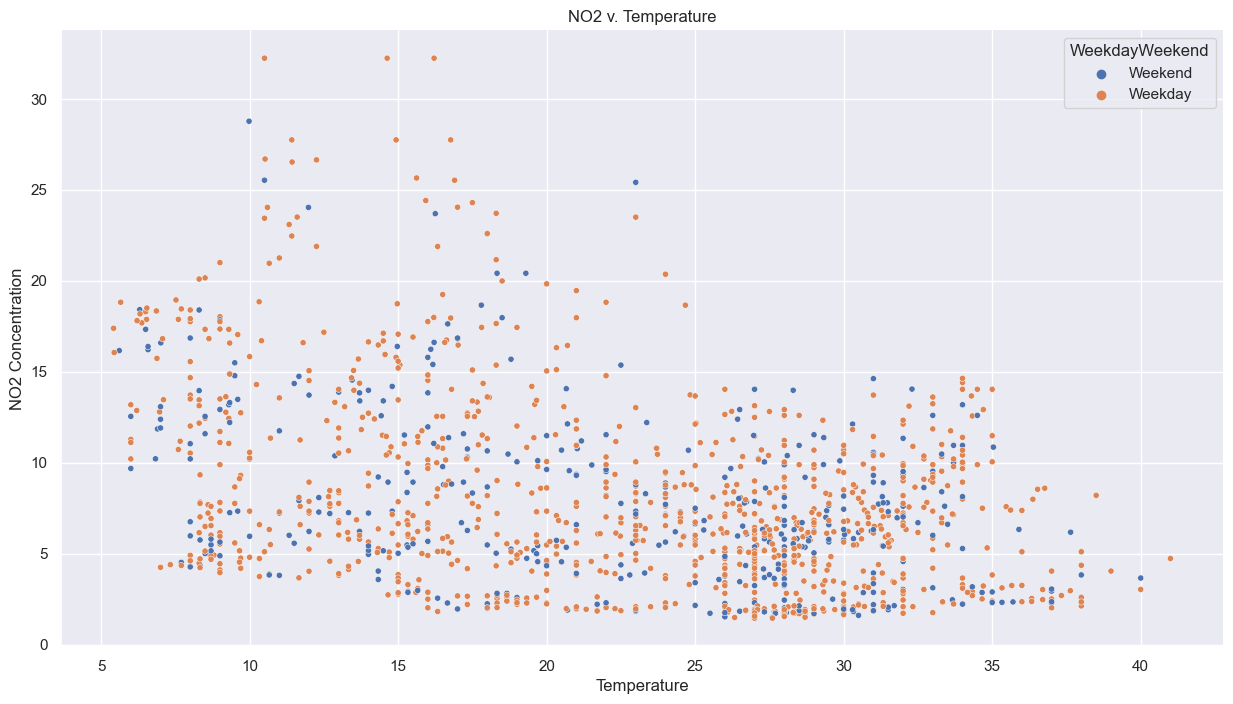

In [37]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine()
sns.set_theme(style="darkgrid")
g = sns.scatterplot(x=aqdf_ppb["Temperature"], y=aqdf_ppb["NO2"], s=20, hue=aqdf_ppb["WeekdayWeekend"])
plt.xlabel("Temperature")
plt.ylabel("NO2 Concentration")
plt.title("NO2 v. Temperature")
plt.show()

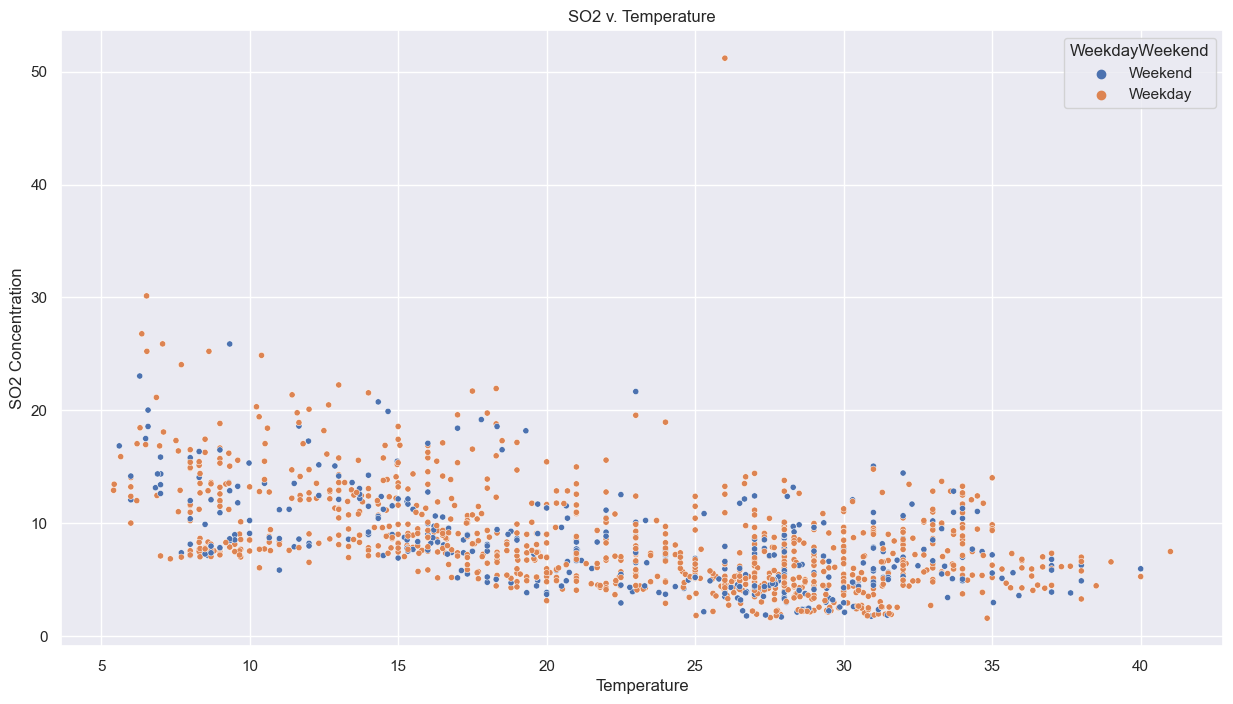

In [87]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x=aqdf_ppb["Temperature"], y=aqdf_ppb["SO2"], s=20, hue=aqdf_ppb["WeekdayWeekend"])
plt.xlabel("Temperature")
plt.ylabel("SO2 Concentration")
plt.title("SO2 v. Temperature")
plt.show()

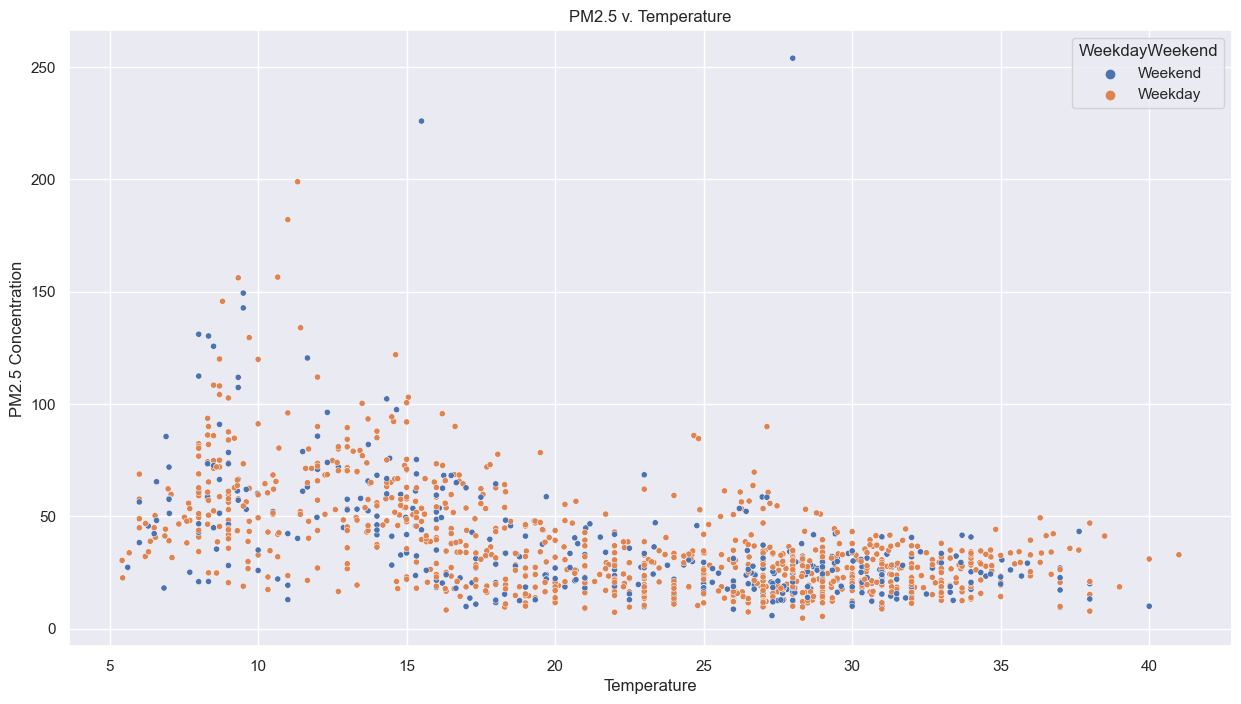

In [88]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x=aqdf_ppb["Temperature"], y=aqdf_ppb["PM2.5"], s=20, hue=aqdf_ppb["WeekdayWeekend"])
plt.xlabel("Temperature")
plt.ylabel("PM2.5 Concentration")
plt.title("PM2.5 v. Temperature")
plt.show()

In these scatter plots of air pollutants vs. temperature, we can see that there is a somewhat negative relationship present. The concentrations of the air pollutants appear to fall as it gets hotter.

We can visualize the correlations through a heatmap.

In [89]:
aqdf_ppb.corr()

,Temperature,Humidity,NO2,SO2,PM2.5,AQI
Temperature,1.000000,-0.187424,-0.400529,-0.523749,-0.544870,-0.596158
Humidity,-0.187424,1.000000,0.036739,-0.090210,0.021783,0.021718
NO2,-0.400529,0.036739,1.000000,0.653659,0.458113,0.525356
SO2,-0.523749,-0.090210,0.653659,1.000000,0.416441,0.505029
PM2.5,-0.544870,0.021783,0.458113,0.416441,1.000000,0.943134
AQI,-0.596158,0.021718,0.525356,0.505029,0.943134,1.000000


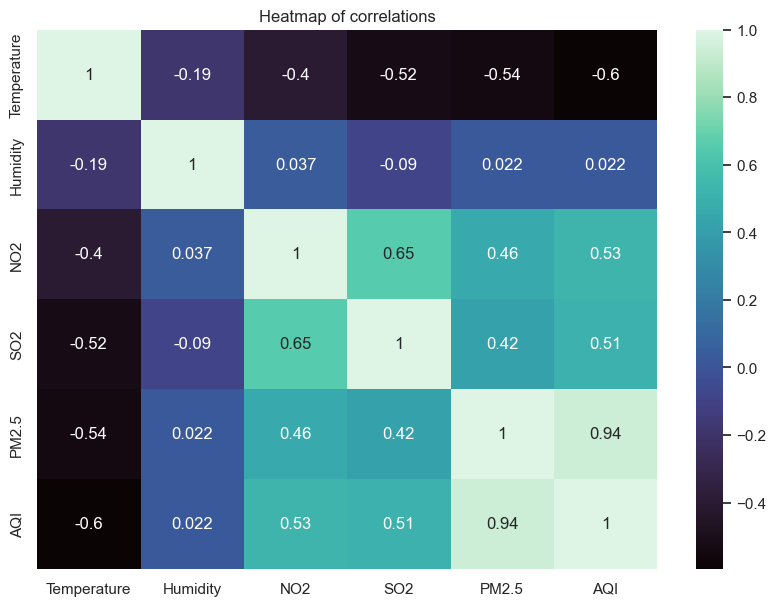

In [42]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(aqdf_ppb.corr(), annot=True, cmap="mako")
plt.title("Heatmap of correlations")
plt.show()

We can clearly see that the air pollutants, namely Sulphur Dioxide (SO2), Nitrogen Dioxide (NO2), and Particulate Matter that is 2.5 micrometers in diameter (PM2.5) appear to be negatively correlated with temperature.

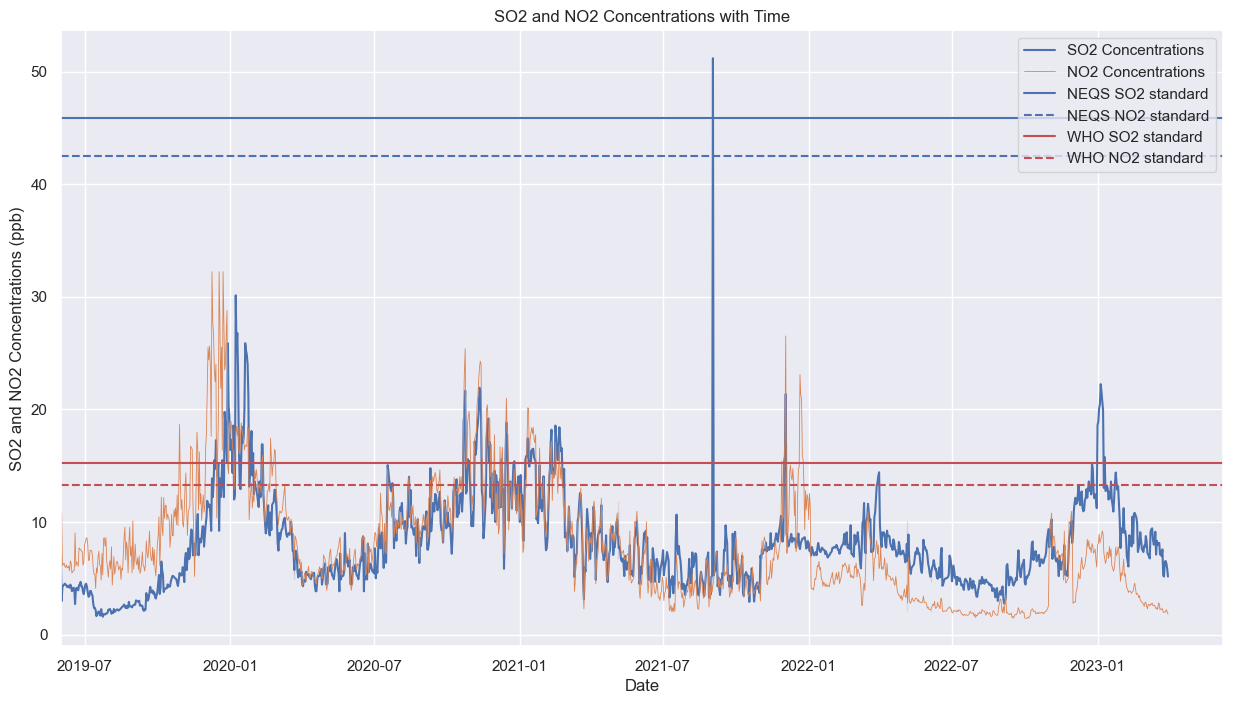

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="SO2", data = aqdf_ppb, label = "SO2 Concentrations")
g=sns.lineplot(x = "Date", y="NO2", data = aqdf_ppb, label = "NO2 Concentrations", lw=.6)
g.axhline(NEQS_so2_ppb, label="NEQS SO2 standard", c = "b")
g.axhline(NEQS_no2_ppb, label="NEQS NO2 standard", c = "b", ls = '--')
g.axhline(WHO_so2_ppb, label="WHO SO2 standard", c = "r")
g.axhline(WHO_no2_ppb, label="WHO NO2 standard", c = 'r', ls = '--')
plt.title("SO2 and NO2 Concentrations with Time")
plt.ylabel("SO2 and NO2 Concentrations (ppb)")
plt.xlabel("Date")
ax.set_xlim(datetime.date(2019, 6, 1))
ax.legend(loc = "upper right")

plt.show()

The series for NO2 and SO2 concentrations appear to follow each other somewhat closely.

We can also note that the NEQS standards in Pakistan are significantly higher than those set by WHO. The SO2 and NO2 concentrations rarely exceed the NEQS standards as compared to the WHO standards. 

We can visualize these series and compare them to their respective standards as set by the NEQS and the WHO separately.

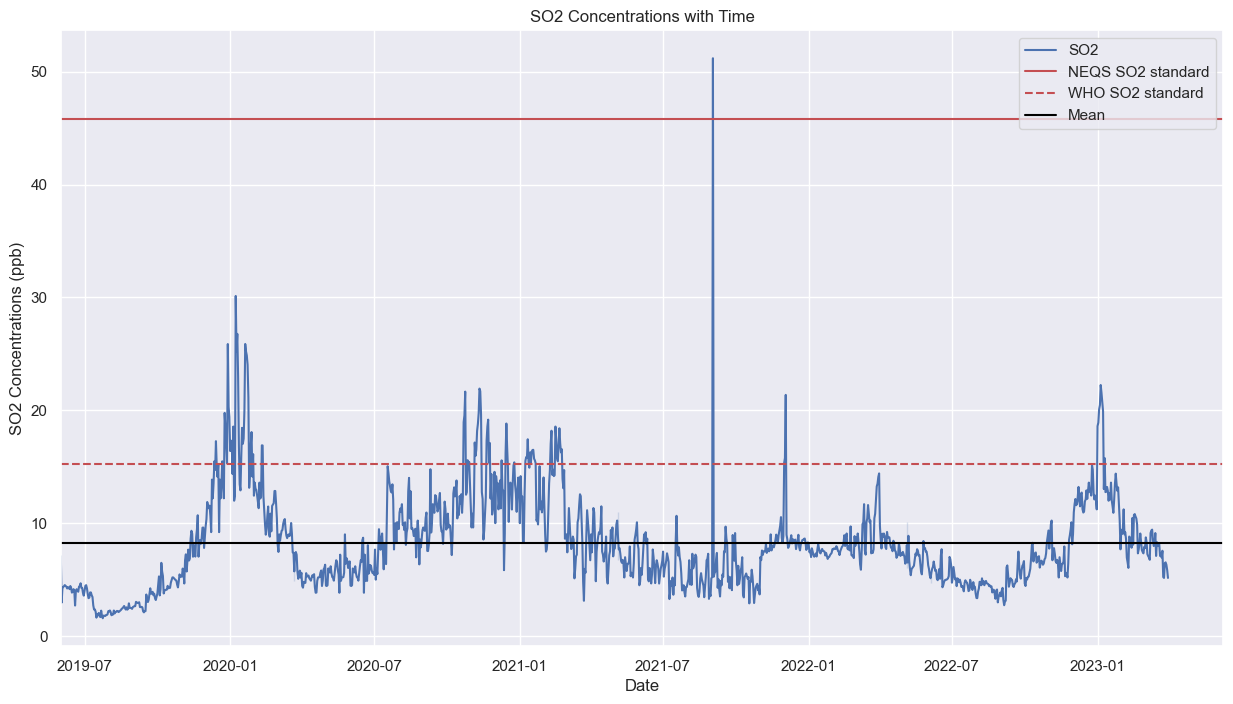

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="SO2", data = aqdf_ppb, label = "SO2")
g.axhline(NEQS_so2_ppb, label="NEQS SO2 standard", c = "r")
g.axhline(WHO_so2_ppb, label="WHO SO2 standard", c = "r", ls="--")
g.axhline(np.mean(aqdf_ppb["SO2"]), label = "Mean", c="black")
plt.title("SO2 Concentrations with Time")
plt.ylabel("SO2 Concentrations (ppb)")
plt.xlabel("Date")
ax.set_xlim(datetime.date(2019, 6, 1))
ax.legend(loc = "upper right")

plt.show()

In [44]:
SO2_neqs_days = len(aqdf_ppb[aqdf_ppb["SO2"] >= NEQS_so2_ppb])
SO2_who_days = len(aqdf_ppb[aqdf_ppb["SO2"] >= WHO_so2_ppb])

In [45]:
print("Number of days above NEQS SO2 limit: ", SO2_neqs_days)
print("Number of days above WHO SO2 limit: ", SO2_who_days)

Number of days above NEQS SO2 limit:  1
Number of days above WHO SO2 limit:  95


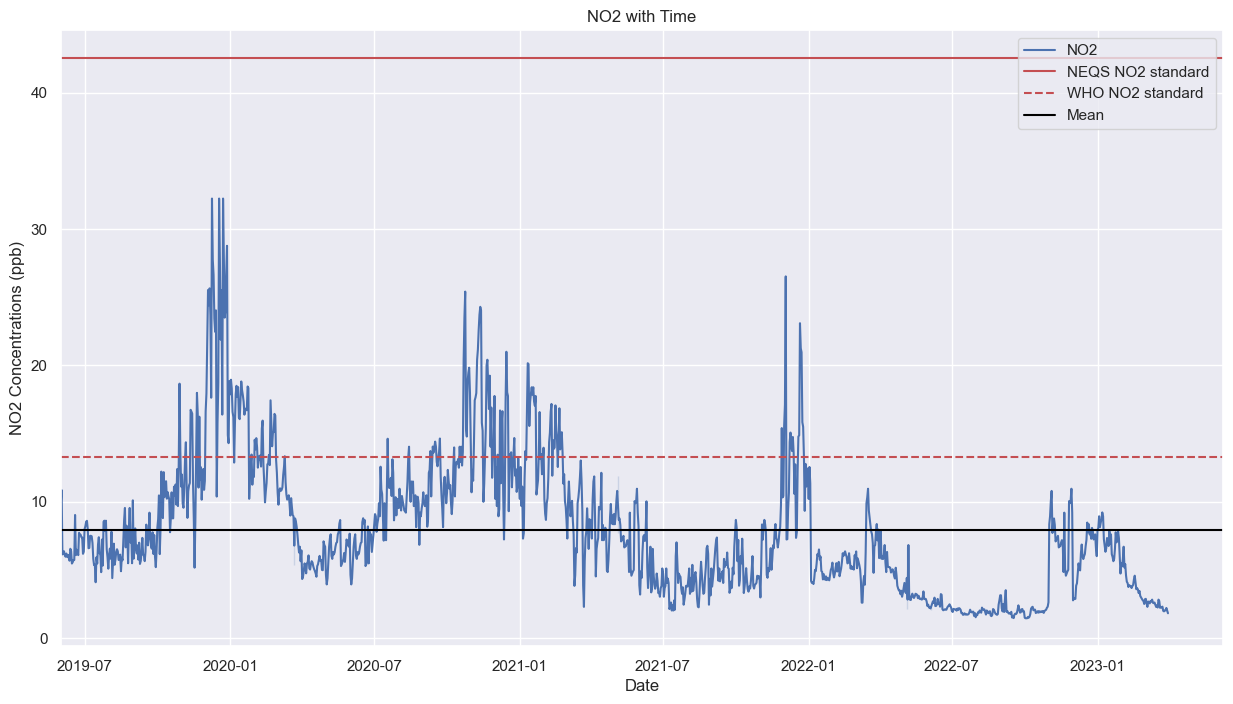

In [95]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="NO2", data = aqdf_ppb, label = "NO2")
g.axhline(NEQS_no2_ppb, label="NEQS NO2 standard", c = "r")
g.axhline(WHO_no2_ppb, label="WHO NO2 standard", c = 'r', ls = '--')
g.axhline(np.mean(aqdf_ppb["NO2"]), label = "Mean", c="black")
plt.title("NO2 Concentrations with Time")
plt.ylabel("NO2 Concentrations (ppb)")
plt.xlabel("Date")
ax.set_xlim(datetime.date(2019, 6, 1))
ax.legend(loc = "upper right")

plt.show()

In [96]:
NO2_neqs_days = len(aqdf_ppb[aqdf_ppb["NO2"] >= NEQS_no2_ppb])
NO2_who_days = len(aqdf_ppb[aqdf_ppb["NO2"] >= WHO_no2_ppb])

In [97]:
print("Number of days above NEQS NO2 limit: ", NO2_neqs_days)
print("Number of days above WHO NO2 limit: ", NO2_who_days)

Number of days above NEQS NO2 limit:  0
Number of days above WHO NO2 limit:  191


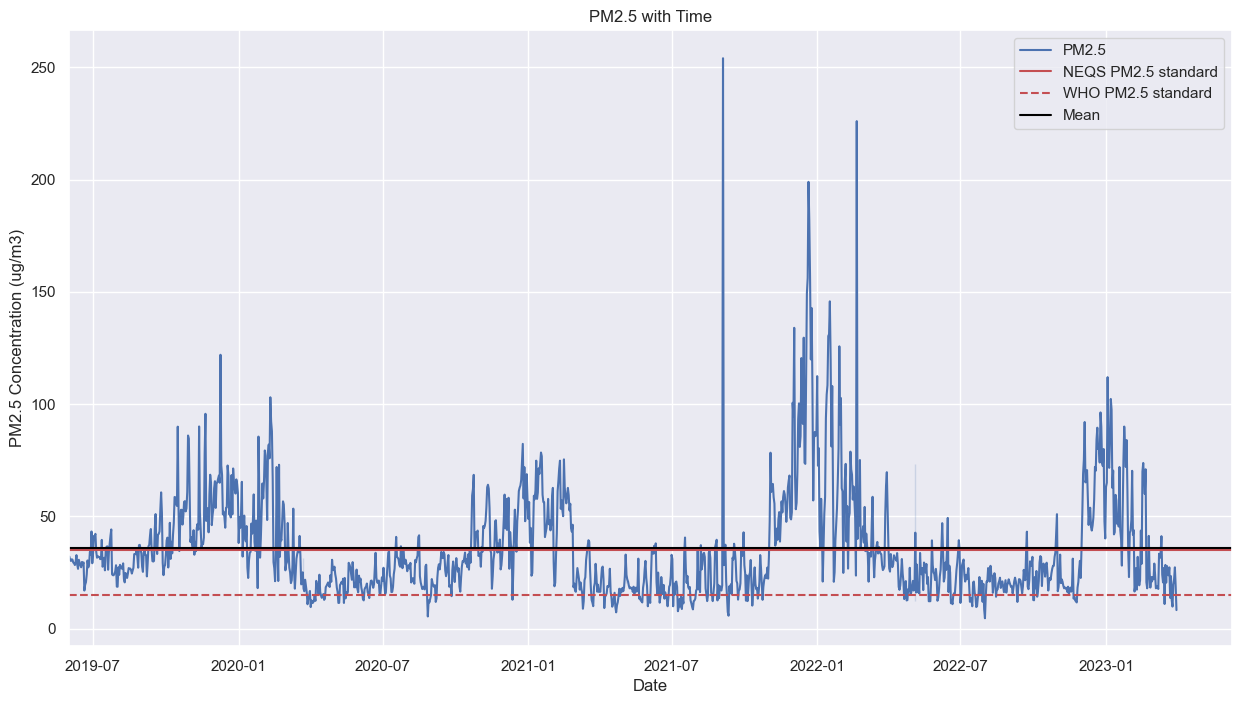

In [98]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="PM2.5", data = aqdf_ppb, label = "PM2.5")
g.axhline(NEQS_pm25, label="NEQS PM2.5 standard", c = "r")
g.axhline(WHO_pm25, label="WHO PM2.5 standard", c = "r", ls='--')
g.axhline(np.mean(aqdf_ppb["PM2.5"]), label="Mean", c = "black", ls='-')
plt.title("PM2.5 with Time")
plt.ylabel("PM2.5 Concentration (ug/m3)")
plt.xlabel("Date")
ax.set_xlim(datetime.date(2019, 6, 1))
ax.legend(loc = "upper right")

plt.show()

In [99]:
PM25_who_days = len(aqdf_ppb[aqdf_ppb["PM2.5"] >= WHO_pm25])
PM25_neqs_days = len(aqdf_ppb[aqdf_ppb["PM2.5"] >= NEQS_pm25])

In [100]:
print("Number of days above NEQS PM2.5 limit: ", PM25_neqs_days)
print("Number of days above WHO PM2.5 limit: ", PM25_who_days)

Number of days above NEQS PM2.5 limit:  492
Number of days above WHO PM2.5 limit:  1265


We can see that the PM2.5 levels cross the NEQS standards on 492 days, even though this standard is set higher than the WHO standard. Taking the WHO PM2.5 concentration level standard, the PM2.5 levels in Islamabad cross that limit on 1265 days out of 1398 total days present in the dataset. This represents a serious cause for concern pertaining to the air quality of Pakistan's capital.

We now move towards the analysis by first checking for stationarity.

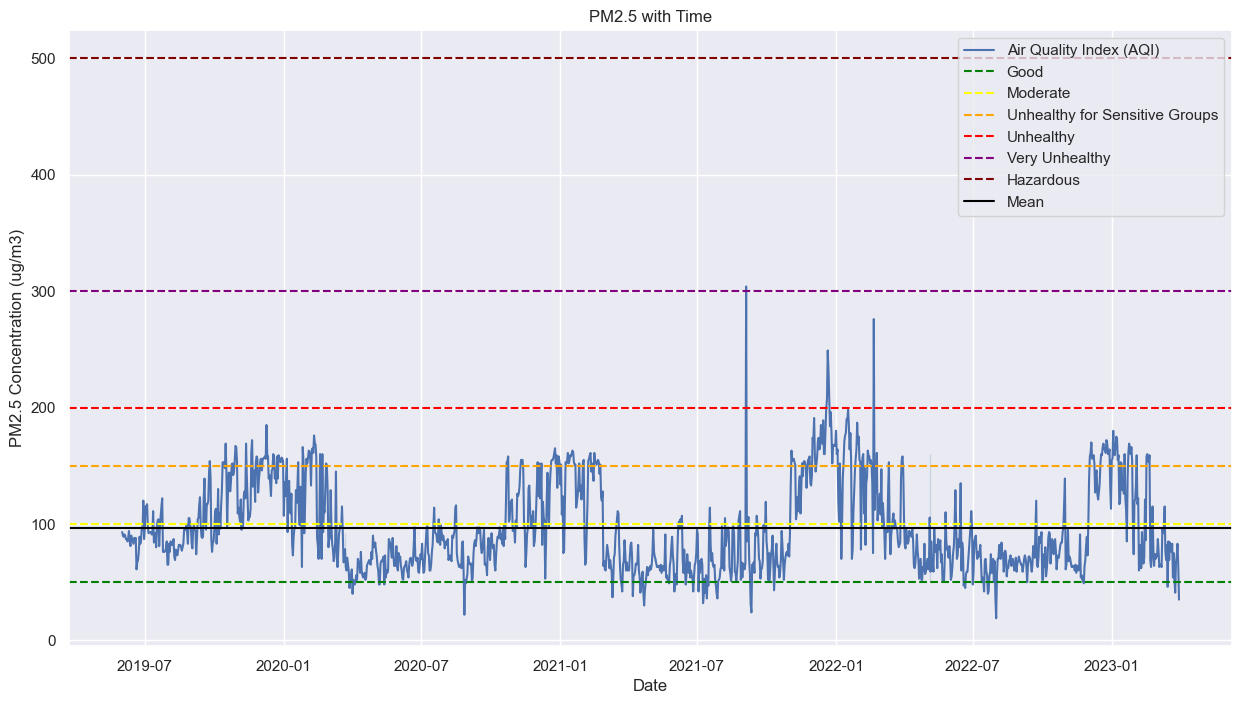

In [103]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="AQI", data = aqdf_ppb, label = "Air Quality Index (AQI)")
g.axhline(50, label="Good", c = "green", ls='--')
g.axhline(100, label="Moderate", c = "yellow", ls='--')
g.axhline(150, label="Unhealthy for Sensitive Groups", c = "orange", ls='--')
g.axhline(200, label="Unhealthy", c = "red", ls='--')
g.axhline(300, label="Very Unhealthy", c = "purple", ls='--')
g.axhline(500, label="Hazardous", c = "maroon", ls='--')
g.axhline(np.mean(aqdf_ppb["AQI"]), c="black", label="Mean", ls = '-')
ax.legend(loc = "upper right")
plt.title("PM2.5 with Time")
plt.ylabel("PM2.5 Concentration (ug/m3)")
plt.xlabel("Date")
plt.show()

In [47]:
above_good_days = len(aqdf_ppb[aqdf_ppb["AQI"] >=51])
unhealthy_sg_days = len(aqdf_ppb[aqdf_ppb["AQI"] >=101])
unhealthy_days = len(aqdf_ppb[aqdf_ppb["AQI"] >=151])
v_unhealthy_days = len(aqdf_ppb[aqdf_ppb["AQI"] >=201])

In [48]:
print("Days above Good AQI values:", above_good_days)
print("Days with Unhealthy for Sensitive Groups AQI:", unhealthy_sg_days)
print("Days with Unhealthy AQI:", unhealthy_days)
print("Days with Very Unhealthy AQI:", v_unhealthy_days)

Days above Good AQI values: 1346
Days with Unhealthy for Sensitive Groups AQI: 484
Days with Unhealthy AQI: 233
Days with Very Unhealthy AQI: 6


In [49]:
aqdf_ppb["Month"] = pd.DatetimeIndex(aqdf_ppb['Date']).month_name()
aqdf_ppb.head()

,Date,Temperature,Humidity,NO2,SO2,PM2.5,Day,WeekdayWeekend,AQI,Month
0,2019-06-01,29.32,33.23,9.891620,7.082859,32.12,Saturday,Weekend,93,June
1,2019-06-02,35.04,30.76,10.853674,2.968383,30.60,Sunday,Weekend,90,June
2,2019-06-03,25.95,36.43,6.133761,4.225266,30.18,Monday,Weekday,89,June
3,2019-06-04,30.15,38.38,6.224120,4.355156,30.91,Tuesday,Weekday,91,June
4,2019-06-05,25.87,36.55,6.362315,4.420102,30.74,Wednesday,Weekday,90,June


In [50]:
aqdf_2020 = aqdf_ppb.loc[aqdf_ppb["Date"]>='2020-01-01']
aqdf_2020 = aqdf_2020.loc[aqdf_2020["Date"]<'2021-01-01']
aqdf_2020.groupby("Month").mean()

,Temperature,Humidity,NO2,SO2,PM2.5,AQI
Month,,,,,,
April,19.457241,59.364828,5.387431,5.083650,17.544138,62.103448
August,32.853548,69.454516,10.141949,9.775933,23.075484,73.741935
December,10.774839,66.094194,12.856311,13.078532,51.109355,132.483871
February,16.607241,56.557931,13.668906,11.805556,56.588966,133.620690
January,7.363871,65.157097,16.060529,18.440032,44.035161,118.645161
July,32.546774,59.036452,9.965861,9.342759,27.150323,82.774194
June,31.369333,47.252000,6.657133,5.839857,19.549000,66.633333
March,17.663636,69.779697,9.323052,7.889524,25.867879,80.181818
May,26.532000,48.517667,6.460115,5.811841,20.269000,67.966667


In [51]:
aqdf_2021 = aqdf_ppb.loc[aqdf_ppb["Date"]>='2021-01-01']
aqdf_2021 = aqdf_2021.loc[aqdf_2021["Date"]<'2022-01-01']
aqdf_2021.groupby("Month").mean()

,Temperature,Humidity,NO2,SO2,PM2.5,AQI
Month,,,,,,
April,23.278667,49.022000,8.223882,8.103137,16.318000,58.566667
August,27.054839,64.818065,4.215825,5.226187,23.814194,75.870968
December,11.030968,56.907097,13.782016,9.206583,104.769355,177.774194
February,14.134286,44.822500,13.166173,13.871145,50.327857,131.250000
January,8.200968,58.474516,14.206890,13.476460,53.908387,137.935484
July,32.709677,52.290323,3.686875,5.728127,17.350323,60.548387
June,31.766667,36.790000,4.982485,6.319561,20.330000,68.066667
March,21.078667,48.044000,8.275439,8.460082,21.485667,70.400000
May,25.438437,39.562500,7.828651,7.376068,19.632500,66.812500


In [52]:
aqdf_2022 = aqdf_ppb.loc[aqdf_ppb["Date"]>='2022-01-01']
aqdf_2022 = aqdf_2022.loc[aqdf_2022["Date"]<'2023-01-01']
aqdf_2022.groupby("Month").mean()


,Temperature,Humidity,NO2,SO2,PM2.5,AQI
Month,,,,,,
April,28.171000,35.823667,4.928677,8.083399,24.027667,76.066667
August,28.701935,73.030645,1.971774,4.213189,19.970968,66.967742
December,13.380000,49.153548,6.080266,12.225123,65.456129,149.709677
February,12.316429,59.641429,5.413929,7.893584,58.506071,139.107143
January,8.455484,71.401935,5.484619,7.400315,75.715161,149.322581
July,29.469000,74.105000,1.901253,4.643335,17.764000,62.033333
June,33.491935,39.458387,2.406250,5.658499,24.862258,78.000000
March,21.595333,49.154333,6.572621,9.660552,38.060667,106.233333
May,32.167097,36.869355,3.238168,6.931649,24.017742,75.290323


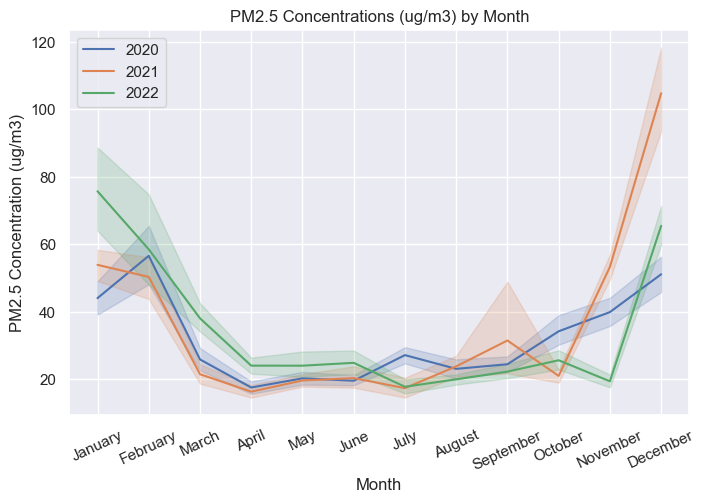

In [172]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=aqdf_2020, y="PM2.5", x="Month", label="2020")
sns.lineplot(data=aqdf_2021, y="PM2.5", x="Month", label="2021")
sns.lineplot(data=aqdf_2022, y="PM2.5", x="Month", label="2022")
plt.xticks(rotation=25)
plt.xlabel("Month")
plt.ylabel("PM2.5 Concentration (ug/m3)")
plt.title("PM2.5 Concentrations (ug/m3) by Month")
plt.show()

For PM2.5, we can see that the levels remain low throughout the years, only increasing at the end of the year before falling at the beginning of the year. The end of 2021 saw a rapid rise in PM2.5 concentrations starting in October.

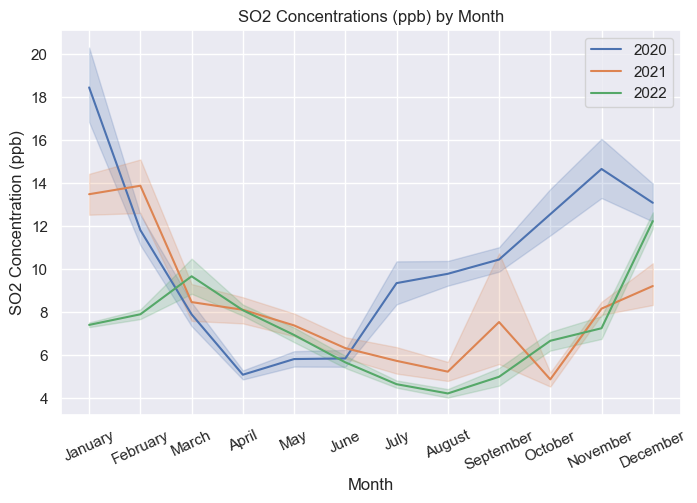

In [173]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=aqdf_2020, y="SO2", x="Month", label="2020")
sns.lineplot(data=aqdf_2021, y="SO2", x="Month", label="2021")
sns.lineplot(data=aqdf_2022, y="SO2", x="Month", label="2022")
plt.xticks(rotation=25)
plt.xlabel("Month")
plt.ylabel("SO2 Concentration (ppb)")
plt.title("SO2 Concentrations (ppb) by Month")
plt.show()

SO2 concentrations fell rapidly in the beginning of 2020, most likely due to the lockdown enforced throughout the country. The concentrations began rising again from June onwards as lockdown was relaxed. Continuing from the upward trend at the end of 2020, the concentration levels in 2021 fell from February to March and remained low throughout the year. The end of 2022 saw a relative rise in the SO2 concentration levels starting from November. 

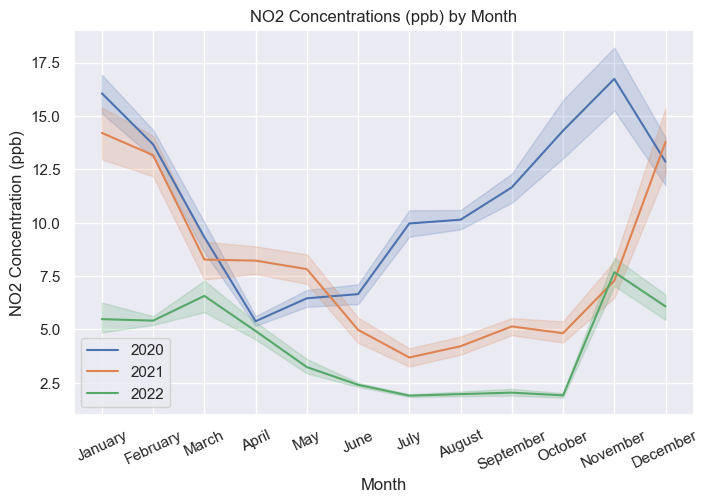

In [176]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=aqdf_2020, y="NO2", x="Month", label="2020")
sns.lineplot(data=aqdf_2021, y="NO2", x="Month", label="2021")
sns.lineplot(data=aqdf_2022, y="NO2", x="Month", label="2022")
plt.xticks(rotation=25)
plt.xlabel("Month")
plt.ylabel("NO2 Concentration (ppb)")
plt.title("NO2 Concentrations (ppb) by Month")
plt.show()

The NO2 concentration levels follow a similar pattern as compared to the SO2 concentration levels, falling till April before rising from June in 2020. The end of 2021 saw a sharp rise in the NO2 levels starting from October.

## 📈 Analysis

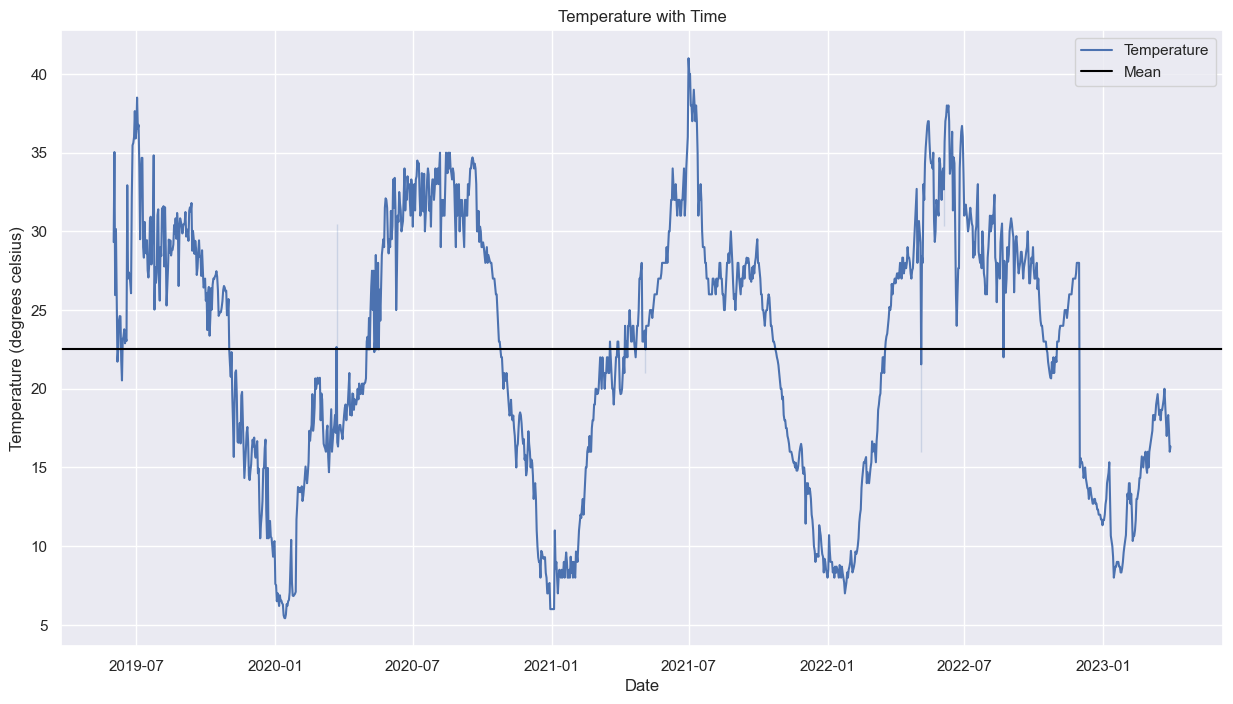

In [101]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="Temperature", data = aqdf_ppb, label = "Temperature")
g.axhline(np.mean(aqdf_ppb["Temperature"]), c="black", label="Mean", ls = '-')
ax.legend(loc = "upper right")
plt.title("Temperature with Time")
plt.ylabel("Temperature (degrees celsius)")
plt.xlabel("Date")
plt.show()

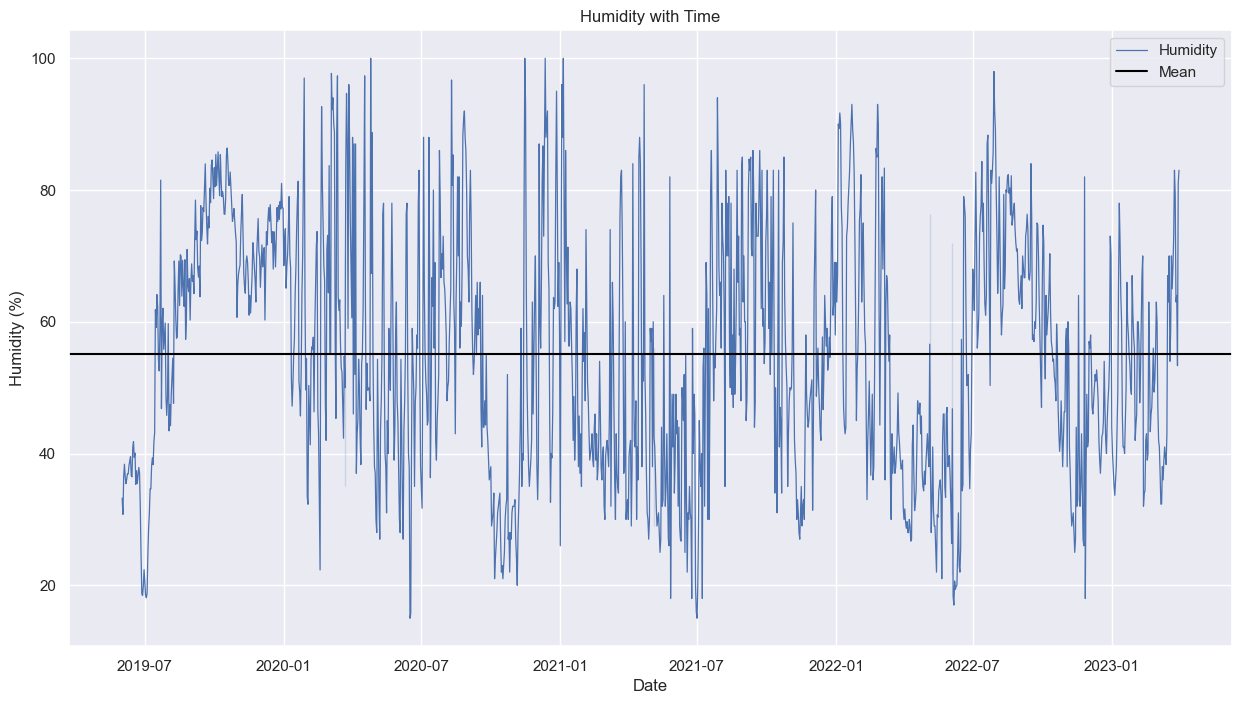

In [102]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="Humidity", data = aqdf_ppb, label = "Humidity", lw=.9)
g.axhline(np.mean(aqdf_ppb["Humidity"]), c="black", label="Mean", ls = '-')
ax.legend(loc = "upper right")
plt.title("Humidity with Time")
plt.ylabel("Humidity (%)")
plt.xlabel("Date")
plt.show()

Both the series for Daily Temperature and Daily Humidity values appear to be stationary.

In [311]:
aug_dickeyfuller = adfuller(aqdf_ppb["AQI"])

print('Augmented DF Statistic: {}'.format(aug_dickeyfuller[0]))
print('p-value: {}'.format(aug_dickeyfuller[1]))
print('Critical Values:')
for key, value in aug_dickeyfuller[4].items():
    print('{}: {}'.format(key, value))

Augmented DF Statistic: -2.917516852793324
p-value: 0.04334861606840112
Critical Values:
1%: -3.435097467737946
5%: -2.8636366587977804
10%: -2.5678862576139467


As the obtained p-value from the augmented dickey fuller test is less than the critical value for 5% significance level, we can reject the null hypothesis that the series is non-stationary. This series is stationary and does not have a unit root.

In [312]:
aug_dickeyfullerSO2 = adfuller(aqdf_ppb["SO2"])

print('Augmented DF Statistic: {}'.format(aug_dickeyfullerSO2[0]))
print('p-value: {}'.format(aug_dickeyfullerSO2[1]))
print('Critical Values:')
for key, value in aug_dickeyfullerSO2[4].items():
    print('{}: {}'.format(key, value))

Augmented DF Statistic: -2.971488854258726
p-value: 0.037644136221996936
Critical Values:
1%: -3.4350768776774996
5%: -2.8636275726388236
10%: -2.5678814189722416


As the obtained p-value from the augmented dickey fuller test is less than the critical value for 5% significance level, we can reject the null hypothesis that the series is non-stationary. This series is stationary and does not have a unit root.

In [313]:
aug_dickeyfullerNO2 = adfuller(aqdf_ppb["NO2"])

print('Augmented DF Statistic: {}'.format(aug_dickeyfullerNO2[0]))
print('p-value: {}'.format(aug_dickeyfullerNO2[1]))
print('Critical Values:')
for key, value in aug_dickeyfullerNO2[4].items():
    print('{}: {}'.format(key, value))

Augmented DF Statistic: -2.540323166157331
p-value: 0.10596891045371293
Critical Values:
1%: -3.435090584482338
5%: -2.8636336213024727
10%: -2.5678846400589763


As the obtained p-value from the augmented dickey fuller test is greater 0.05 for 5% significance level, we fail to reject the null hypothesis that the series is non-stationary. This series is non stationary and does have a unit root. However, the series appears to be stationary at the 10% significance level.

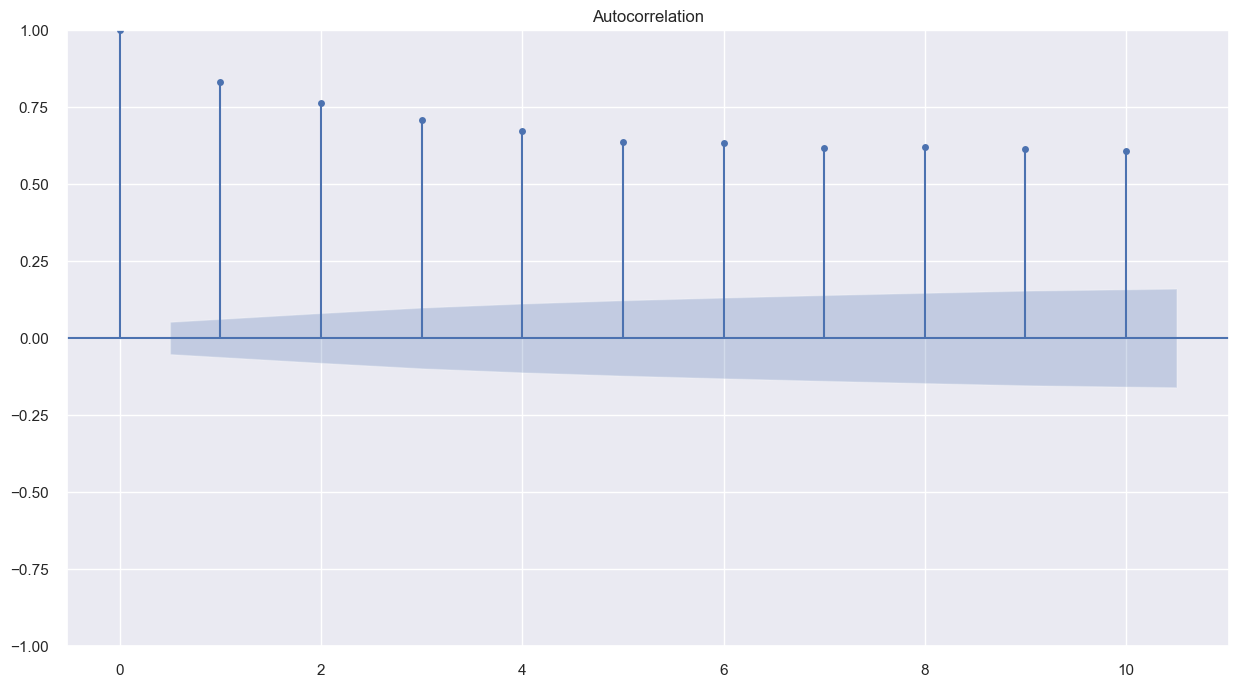

In [314]:
fig, ax = plt.subplots(figsize=(15,8))

plot_acf(aqdf_ppb["AQI"], lags=10, ax=ax)

plt.show()

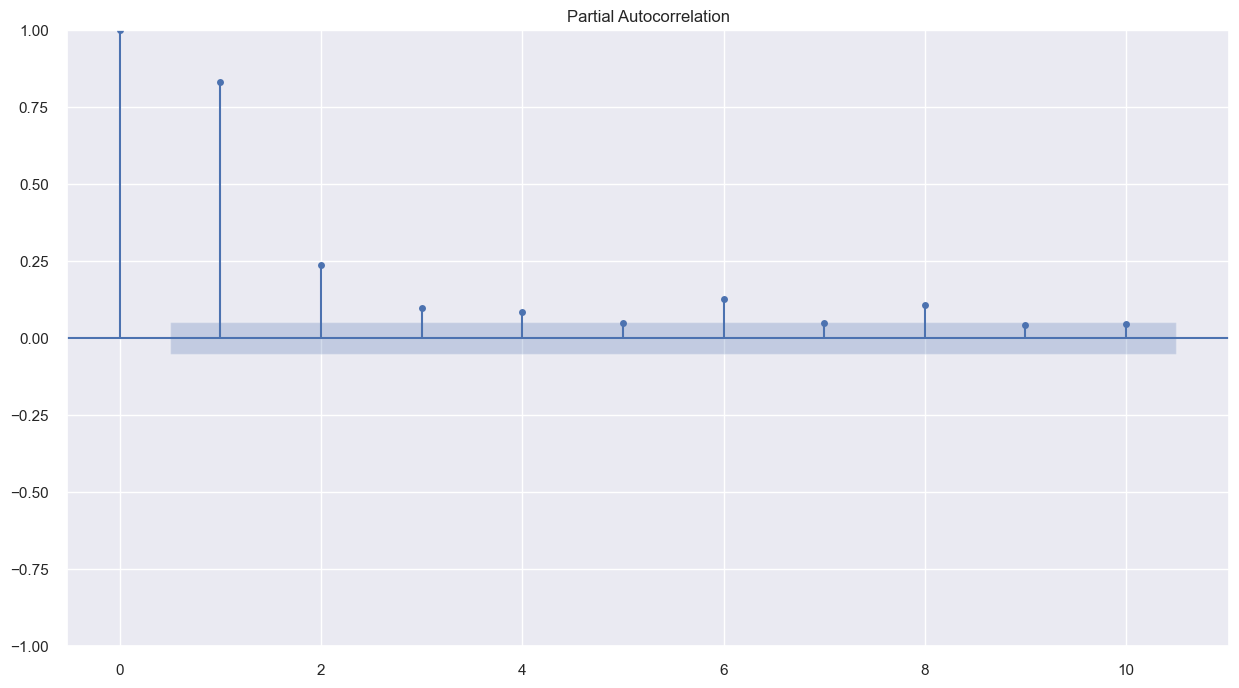

In [315]:
fig, ax = plt.subplots(figsize=(15,8))

plot_pacf(aqdf_ppb["AQI"], lags=10, ax=ax)

plt.show()

## 🧮 Forecasting

For the parameters of the ARIMA model, we set d = 0 as the series is stationary. p and q are set based on the partial autocorrelation and autocorrelation plots

In [316]:
model1 = ARIMA(aqdf_ppb["AQI"], order=(1, 0, 1))
fit1 = model1.fit()

In [317]:
print(fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1398
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6213.545
Date:                Fri, 21 Jul 2023   AIC                          12435.090
Time:                        22:24:16   BIC                          12456.062
Sample:                             0   HQIC                         12442.931
                               - 1398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.3983      6.107     15.784      0.000      84.428     108.368
ar.L1          0.9315      0.012     75.642      0.000       0.907       0.956
ma.L1         -0.3592      0.014    -25.125      0.0

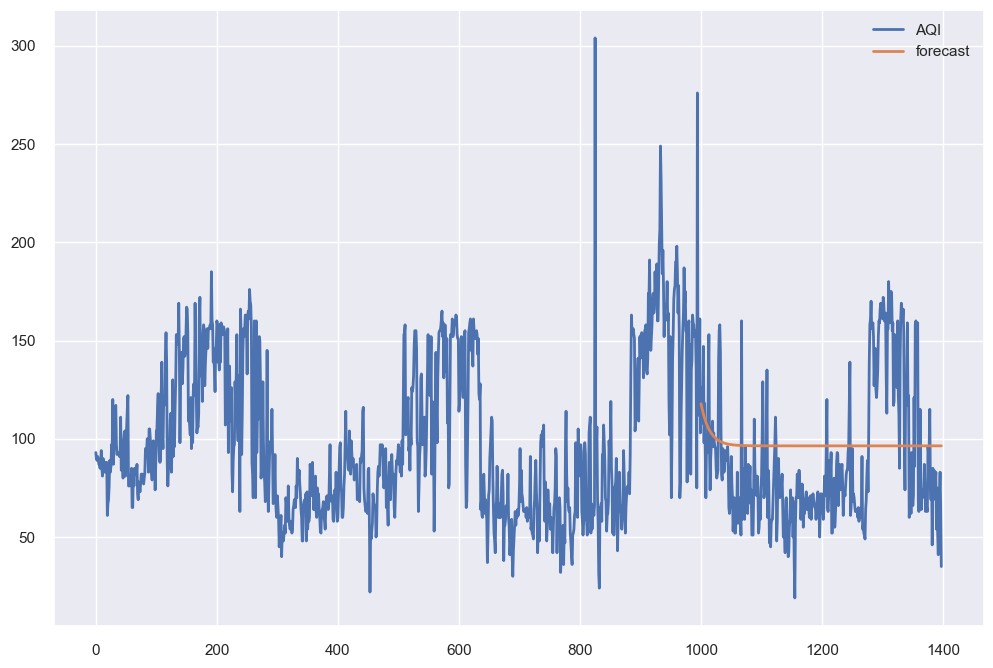

In [318]:
aqdf_ppb['forecast']=fit1.predict(start=1000,end=1397,dynamic=True)
aqdf_ppb[['AQI','forecast']].plot(figsize=(12,8), lw=2)
plt.xlabel("Days")
plt.ylabel("AQI")
plt.show()

It appears that the ARIMA model does not perform as well in predicting the AQI values when compared to the actual AQI values. Thus we turn towards machine learning techniques with PyCaret.

In [319]:
aqdf_ppb.drop('forecast', axis=1, inplace=True)

In [320]:
from pycaret.time_series import *
# initialize setup
setup(aqdf_ppb["AQI"], fh = 30, fold = 5, session_id = 123)



,Description,Value
0,session_id,123
1,Target,AQI
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1398, 1)"
5,Transformed data shape,"(1398, 1)"
6,Transformed train set shape,"(1368, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [321]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,1398.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,96.900572
3,Summary,Statistics,Transformed,Median,,85.0
4,Summary,Statistics,Transformed,Standard Deviation,,38.428313
5,Summary,Statistics,Transformed,Variance,,1476.735275
6,Summary,Statistics,Transformed,Kurtosis,,0.304285
7,Summary,Statistics,Transformed,Skewness,,0.844699
8,Summary,Statistics,Transformed,# Distinct Values,,162.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",12597.547903


In [322]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.5022,1.1591,26.5885,30.2630,0.2445,0.2541,-1.7314,0.4060
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.7678,1.3628,31.2615,35.5660,0.2600,0.2922,-3.1377,0.2020
naive,Naive Forecaster,1.7853,1.4258,31.5933,37.2355,0.2583,0.3080,-2.9627,0.0160
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8066,1.3608,31.9390,35.5041,0.2770,0.3019,-4.3159,0.2740
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.8496,1.3931,32.7044,36.3464,0.2863,0.3047,-3.2929,0.1440
exp_smooth,Exponential Smoothing,1.8852,1.4087,33.3593,36.7832,0.3102,0.3248,-3.8964,0.0680
theta,Theta Forecaster,1.8856,1.4096,33.3658,36.8060,0.3105,0.3248,-3.9236,0.0180
ets,ETS,1.8934,1.4250,33.5030,37.2084,0.3084,0.3260,-3.9531,0.0420
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.9083,1.4535,33.7584,37.9429,0.3115,0.3245,-4.2903,0.3740
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.9349,1.5318,34.2920,40.0334,0.3680,0.3295,-5.9400,0.3120


PyCaret trains a number of models and selects the model with the best score. With this dataset, it appears that Random Forest with conditional deseasonalize and detrending performs the best with lowest scores across MASE, RMSSE, MAE, RMSE, MAPE, and SMAPE.

In [323]:
final_best = finalize_model(best)

y_preds = predict_model(final_best, fh = 31)


In [324]:
pred_list = y_preds["y_pred"].to_list()

In [325]:
pred_list

[30.6427,
 48.773,
 49.0448,
 51.9337,
 58.967,
 60.8908,
 64.0605,
 75.773,
 86.5087,
 69.444,
 69.2656,
 69.3807,
 72.3078,
 72.6568,
 85.9475,
 84.4378,
 84.5555,
 86.4692,
 85.3733,
 83.7116,
 87.4287,
 81.6429,
 75.7833,
 78.5187,
 78.3612,
 76.964,
 81.9187,
 74.6646,
 75.9219,
 72.638,
 89.653]

In [326]:
aqdf_ppb

,Date,Temperature,Humidity,NO2,SO2,PM2.5,Day,WeekdayWeekend,AQI
0,2019-06-01,29.32,33.23,9.891620,7.082859,32.12,Saturday,Weekend,93
1,2019-06-02,35.04,30.76,10.853674,2.968383,30.60,Sunday,Weekend,90
2,2019-06-03,25.95,36.43,6.133761,4.225266,30.18,Monday,Weekday,89
3,2019-06-04,30.15,38.38,6.224120,4.355156,30.91,Tuesday,Weekday,91
4,2019-06-05,25.87,36.55,6.362315,4.420102,30.74,Wednesday,Weekday,90
...,...,...,...,...,...,...,...,...,...
1393,2023-03-27,18.00,63.00,2.025098,6.456328,19.70,Monday,Weekday,67
1394,2023-03-28,18.33,64.00,2.030413,6.536555,22.00,Tuesday,Weekday,72
1395,2023-03-29,17.33,53.33,2.205815,6.326437,27.33,Wednesday,Weekday,83
1396,2023-03-30,16.00,81.00,2.019783,5.856539,18.90,Thursday,Weekday,65


In [327]:
aqdf_preds = aqdf_ppb[["Date", "AQI"]]

In [328]:
aqdf_preds

,Date,AQI
0,2019-06-01,93
1,2019-06-02,90
2,2019-06-03,89
3,2019-06-04,91
4,2019-06-05,90
...,...,...
1393,2023-03-27,67
1394,2023-03-28,72
1395,2023-03-29,83
1396,2023-03-30,65


In [329]:
future_dates = pd.date_range(start='2023-04-01', end='2023-05-01')

pred_dict = {"Date":future_dates, "Forecast":pred_list}

In [330]:
pred_df = pd.DataFrame(pred_dict)

In [331]:
pred_df

,Date,Forecast
0,2023-04-01,30.6427
1,2023-04-02,48.7730
2,2023-04-03,49.0448
3,2023-04-04,51.9337
4,2023-04-05,58.9670
5,2023-04-06,60.8908
6,2023-04-07,64.0605
7,2023-04-08,75.7730
8,2023-04-09,86.5087
9,2023-04-10,69.4440


In [332]:
df_list = [aqdf_preds, pred_df]

In [333]:
aqdf_preds = pd.concat(df_list)

In [334]:
aqdf_preds.reset_index(drop=True, inplace=True)

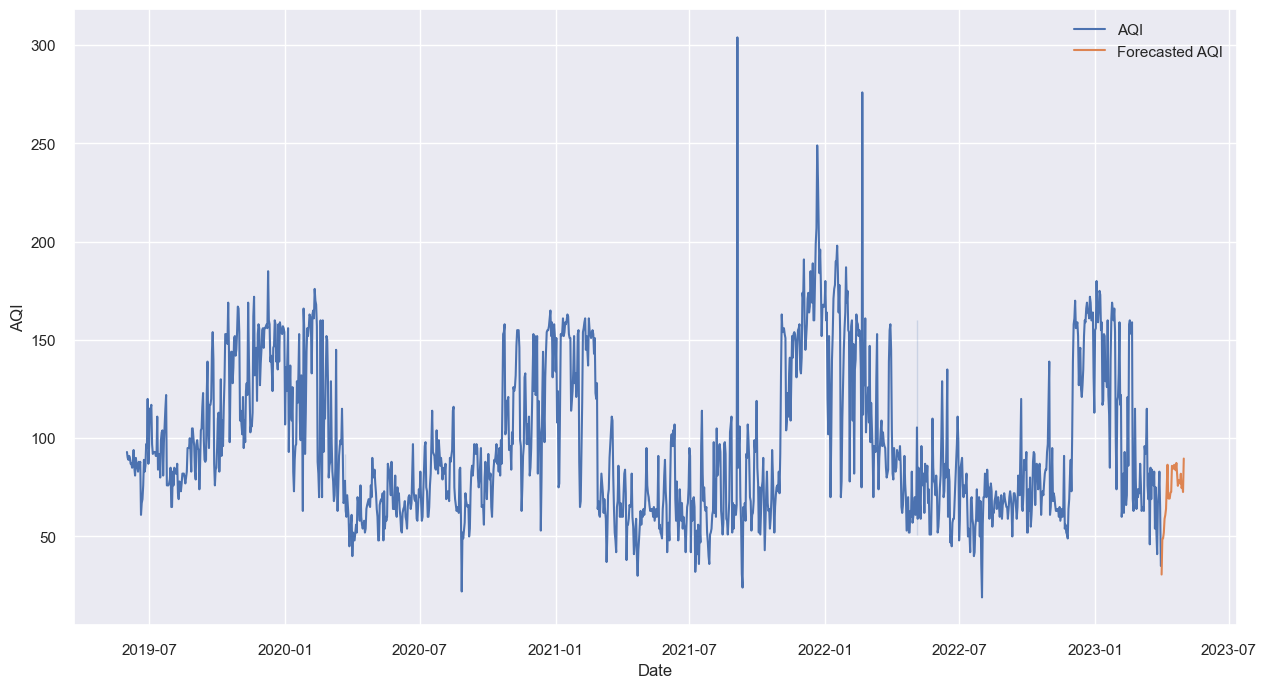

In [338]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="AQI", data = aqdf_preds, label = "AQI")
g=sns.lineplot(x = "Date", y="Forecast", data = aqdf_preds, label = "Forecasted AQI")

We can zoom in to see the predictions more clearly.

In [339]:
zoomed_df = aqdf_preds.loc[aqdf_preds["Date"]>="2023-01-01"]

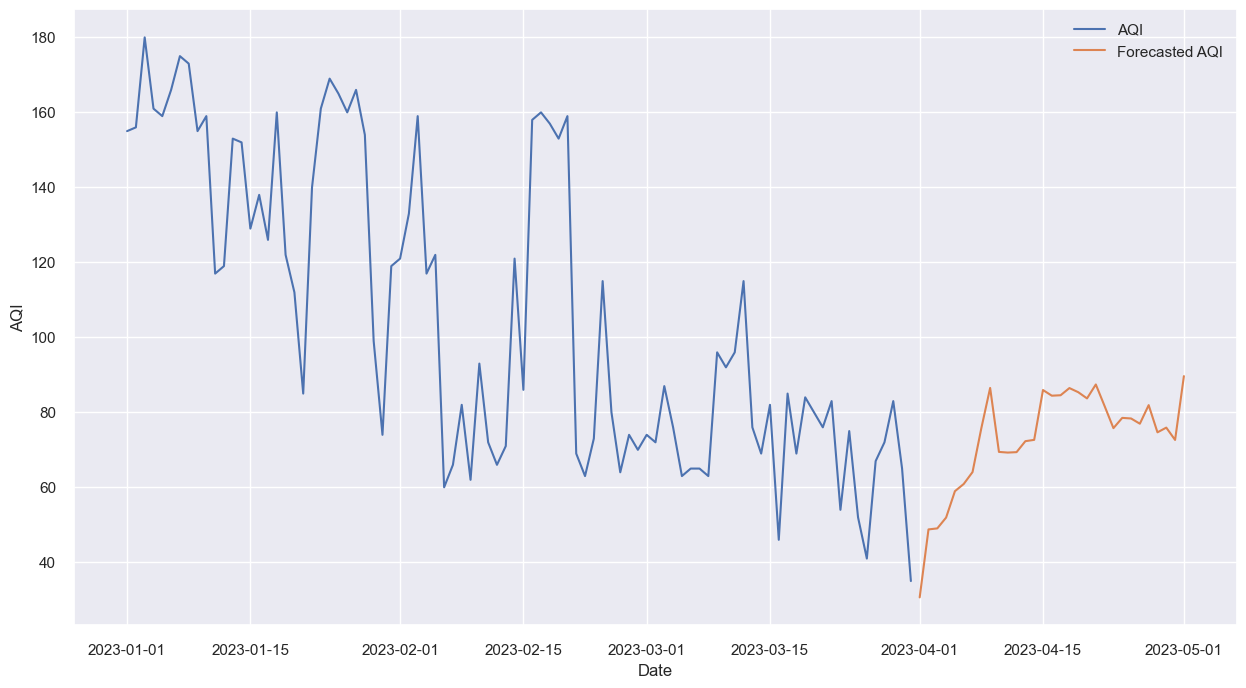

In [340]:
fig, ax = plt.subplots(figsize=(15,8))
g=sns.lineplot(x = "Date", y="AQI", data = zoomed_df, label = "AQI")
g=sns.lineplot(x = "Date", y="Forecast", data = zoomed_df, label = "Forecasted AQI")

The forecasted values for the month of April continue on from the downward trend observed from the beginning of this year. The model forecasts that the AQI values will rise from the low point at the beginning of the month to above 80 by the start of May, 2023.